In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import sys
import os

from misc import rcsetup
from ImageData import ImageData, preprocess
from ExptTrace import ExptTrace
from FileManager import FileManager

rcsetup()

sys.path.append("../")

from feature_decomp import generate_fra_monomials
from utils import ensure_torch, ensure_numpy
from data import get_powerlaw
from kernels import GaussianKernel, LaplaceKernel

## Direct powerlaw check

In [4]:
# SYNTHETIC DATA
################

DATA_DIM = 50
KERNEL_WIDTH = 4
P_MODES = 1_000_000
kerneltype = LaplaceKernel
data_eigval_exp = 1.3

data_eigvals = get_powerlaw(DATA_DIM, data_eigval_exp, offset=6)

d_eff = 1/(data_eigvals**2).sum()
print(f"effective dim = {d_eff:.2f}")

eval_level_coeff = kerneltype.get_level_coeff_fn(data_eigvals=data_eigvals,
                                                 kernel_width=KERNEL_WIDTH)
fra_eigvals, monomials = generate_fra_monomials(data_eigvals, P_MODES, eval_level_coeff)
degrees = np.array([m.degree() for m in monomials])

effective dim = 25.17


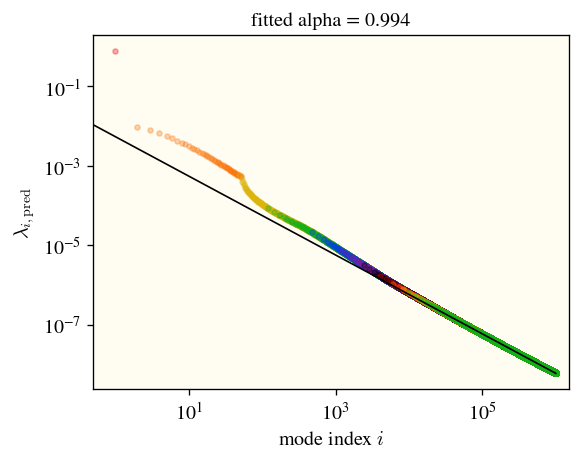

In [8]:
def fit_linear(idxs, eigvals, cutoff=20_000):
    log_x = np.log(idxs[-cutoff:])
    log_y = np.log(eigvals[-cutoff:])
    A     = np.vstack([log_x, np.ones_like(log_x)]).T
    slope, intercept = np.linalg.lstsq(A, log_y, rcond=None)[0]

    alpha = -slope

    return alpha, np.exp(intercept)

colors = ['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"]

fig, ax = plt.subplots(1, 1, figsize=(5,4))

for degree in np.unique(degrees):
    # if degree > 19:
    #     continue
    idxs = np.where(np.array(degrees) == degree)[0]
    ax.scatter(1+idxs, fra_eigvals[idxs], color=colors[degree%7], marker='.', alpha=0.3)

idxs = 1+np.arange(len(fra_eigvals))
alpha, c = fit_linear(idxs, fra_eigvals, cutoff=990_000)
xx = np.logspace(-1, 6, base=10)
ax.plot(xx, c*xx**(-alpha), color='black', lw=1)
ax.set_title(f"fitted alpha = {alpha:.3f}")

ax.set_xlim(.5, 1.5*P_MODES)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(f'mode index $i$')
ax.set_ylabel(f'$\lambda_{{i,\mathrm{{pred}}}}$')

plt.tight_layout()
plt.show()

## Tailsum

In [132]:
# SYNTHETIC DATA
################

DATA_DIM = 200
KERNEL_WIDTH = 4
kerneltype = LaplaceKernel
data_eigval_exp = 1.2

data_eigvals = get_powerlaw(DATA_DIM, data_eigval_exp, offset=6)

d_eff = 1/(data_eigvals**2).sum().item()
print(f"effective dim = {d_eff:.2f}")

eval_level_coeff = kerneltype.get_level_coeff_fn(data_eigvals=data_eigvals,
                                                 kernel_width=KERNEL_WIDTH)

effective dim = 51.60


In [137]:
def compute_homogeneous_polynomial(gammas, max_order):
    partial_sums = np.zeros((max_order + 1, len(gammas)))
    partial_sums[0] = 1
    for i in range(1, max_order + 1):
        partial_sums[i] = (partial_sums[i-1] * gammas).cumsum()

    return partial_sums[:,-1]

def compute_wick_coeff(d_eff, ell):
    return np.prod([1 + (2*i)/d_eff for i in range(ell)])

import math

def anis_wick_bell(lambdas, ell):
    """
    Return E[S^ell] for S = ||x||^2 = sum_i lambda_i * Z_i^2,
    where Z_i ~ N(0,1) iid and lambdas are the variances (eigenvalues).
    Uses cumulants + Bell (via recursion).
    """
    lam = np.asarray(lambdas, dtype=float)
    # power sums p_k = sum_i lambda_i^k
    p = [np.sum(lam**k) for k in range(1, ell+1)]
    # cumulants kappa_k = 2^{k-1} (k-1)! p_k
    kappa = [2**(k-1) * math.factorial(k-1) * p[k-1] for k in range(1, ell+1)]
    # moments m_n via recursion: m_0 = 1
    m = [1.0] + [0.0]*ell
    for n in range(1, ell+1):
        s = 0.0
        for k in range(1, n+1):
            s += math.comb(n-1, k-1) * kappa[k-1] * m[n-k]
        m[n] = s
    return m[ell]

n_levels = 100
partial_sums = compute_homogeneous_polynomial(data_eigvals.cpu().numpy(), n_levels - 1)
level_coeffs = np.array([eval_level_coeff(i) for i in range(n_levels)])
# wick_coeffs = np.array([compute_wick_coeff(d_eff, i) for i in range(n_levels)])

wick_coeffs = np.array([anis_wick_bell(data_eigvals.cpu().numpy(), i) for i in range(n_levels)])

level_traces = partial_sums * level_coeffs
wick_traces = partial_sums * level_coeffs / wick_coeffs
print("level traces")
print(level_traces[:10])
print(level_traces[-10:])
print()
print("wick traces:")
print(wick_traces[:10])
print(wick_traces[-10:])

level traces
[0.77880078 0.0973501  0.03101145 0.01638628 0.01090342 0.00827223
 0.00685833 0.00608039 0.00569308 0.00558596]
[1.65884984e+34 9.44504190e+34 5.43783687e+35 3.16534400e+36
 1.86267137e+37 1.10795315e+38 6.66080486e+38 4.04672367e+39
 2.48430148e+40 1.54092791e+41]

wick traces:
[0.77880078 0.0973501  0.02985435 0.01460246 0.00863789 0.0055879
 0.00378389 0.00262109 0.00183187 0.00128013]
[8.37381581e-27 4.14452766e-27 2.05149149e-27 1.01556251e-27
 5.02788221e-28 2.48945503e-28 1.23271734e-28 6.10466788e-29
 3.02342502e-29 1.49752579e-29]


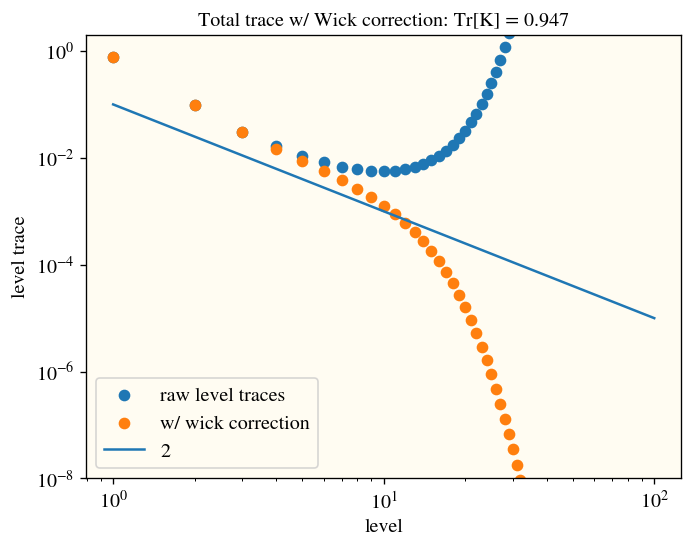

In [143]:
idxs = 1+np.arange(len(level_traces))
plt.scatter(idxs, level_traces, label='raw level traces')
plt.scatter(idxs, wick_traces, label='w/ wick correction')
plt.plot(idxs, .1*idxs**(-2.), label='2')
plt.ylim(1e-8, 2)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('level')
plt.ylabel('level trace')
plt.title(f"Total trace w/ Wick correction: Tr[K] = {wick_traces[:].sum():.3f}")
plt.legend()
plt.show()